# Performance of our model for each litter. More frequent litter on the streets has better performance.

In [ ]:
# Install OSMNX only if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install osmnx
    !pip install matplotlib==3.1.1 

#GridSearch for each litter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn

from google.colab import files

import requests

# Read the data

In [ ]:
# Load datasets if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1tfAjKLhhl3lteqf_EkFoyIPY2IdBJFVn'
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(downloaded.metadata['title'])
    f = open("V2data_6mounts2022.csv.zip", "wb")
    f.write(downloaded.content.getbuffer())
    f.close()
    !unzip V2data_6mounts2022.csv.zip

Archive:  V2data_6mounts2022.csv.zip
  inflating: data.csv                
  inflating: __MACOSX/._data.csv     


In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/data_processor.py')
    with open('data_processor.py', 'w') as f:
        f.write(r.text)
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/darkzone_creator.py')
    with open('darkzone_creator.py', 'w') as f:
        f.write(r.text)

import data_processor 
import darkzone_creator

In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: df_main_url = '/content/data.csv'
else: df_main_url = '../../../Information/output/datav2.csv'
amenities_df = pd.read_csv(df_main_url, dtype = {'place.id': object})
amenities_df.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
amenities_df = data_processor.clean_df(amenities_df)
amenities_df = data_processor.aggregate_df(amenities_df)
amenities_df['row_type'] = "ground truth"
amenities_df = data_processor.make_date_features(amenities_df)
amenities_df = data_processor.make_coordinates_features(amenities_df)
amenities_df = data_processor.make_edge_length_feature(amenities_df)
amenities_df = data_processor.make_weather_features(amenities_df)
amenities_df, osm_columns = data_processor.make_osm_features(amenities_df)

#Function with pypeline

In [ ]:
def score_for_litter(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = ['osm_highway', 'edge_id',
                                'month', 'day', 'weekday', 'holiday', 'atm', 'bar', 
                                'bench', 'childcare', 'cinema', 'clinic', 'fast_food',
                                'fountain', 'fuel', 'ice_cream', 'kindergarten', 'marketplace',
                                'nightclub', 'parking', 'recycling', 'school', 'taxi', 'toilets', 
                                'vending_machine', 'waste_basket', 'waste_disposal']
  all_numeric_features = ['temperature_max', 'precipitation', 
                            'snowfall', 'humidity_max', 'cloud_coverage', 
                            'wind_speed_max', 'lat_north', 'lon_west', 'temperature_min', 'temperature_mean', 
                            'humidity_min', 'humidity_mean', 'wind_speed_min', 'wind_speed_mean', 'lat_south', 
                            'lon_east']
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical and numeric transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer,
                                                       numeric_features),
                                               ("cat", categorical_transformer,
                                                       categorical_features)])
  #Model
  poisson_model = linear_model.PoissonRegressor()

  pipeline_poisson = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("poisson_model", poisson_model)
                              ])
  
  grid_search = {'poisson_model__alpha' : [1e-5, 1e-4, 1e-3],
               'poisson_model__max_iter' : [1000],
               }
               
  model = GridSearchCV(estimator=pipeline_poisson, param_grid=grid_search,
                     scoring='neg_mean_poisson_deviance', verbose=5, n_jobs=-1)
  model.fit(X_train,y_train)

  #prediction = model.best_estimator_.predict(X_test)
  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model


### Model

In [ ]:
df_log_valeria = pd.DataFrame(columns = ['model', 'features', 'litter', 'score'])

In [ ]:
litter_list = amenities_df.columns[4:34]

# litter_list = ['1', '2', '3', '4', '5', '7', '8','10', '13', '14', '16', '19', '21', '25',
#                '26', '27', '28', '29', '30', '31', '32', '33', '35', '36', '37', '39', '49', '61', '63']

for lit in litter_list:
  score, cols, model = score_for_litter(lit, amenities_df)
  df_log_valeria=df_log_valeria.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
  print(f'score for litter {lit}: {score}')

In [ ]:
df_log_valeria.head()

,model,features,litter,score
0,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",1,0.546515
1,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",2,0.634474
2,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",3,0.417449
3,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",4,0.636285
4,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",5,0.315096


In [ ]:
lit_dict = {
    '1': 'Cigarette',
    '2': 'Leaf',
    '3': 'Leaves',
    '4': 'Paper/Carton',
    '5': 'CAN',
    '7': 'Glass bottle',
    '8': 'PET',
    '9': 'Carton drink',
    '10': 'FF Cup',
    '11': 'FF Foam Polystrene',
    '12': 'Other Foam Polystrene',
    '13': 'Food packaging',
    '14': 'Newspaper',
    '15': 'Small bag',
    '16': 'Glass Splinter',
    '17': 'Syringe',
    '18': 'Organic food littering',
    '19': 'Dog fouling',
    '21': 'Garbage bags',
    '22': 'Sand/Grit/Granulate',
    '23': 'Chewing- gum',
    '24': 'Vomit',
    '25': 'FF Cup',
    '26': 'FF Lid',
    '27': 'FF Straw',
    '28': 'FF Fries cartin',
    '29': 'Unclear bottles',
    '30': 'FF Burger Box',
    '31': 'FF Paper',
    '32': 'FF Other Paper',
    '33': 'iQos',
    '34': 'Confettis (pile)',
    '35': 'Medium/big stain',
    '36': 'Transparent plastic',
    '37': 'Opaque plastic',
    '38': 'Fabric',
    '39': 'Unrecognizable',
    '40': 'Capsule',
    '41': 'Carcass',
    '42': 'Furniture',
    '43': 'Tag',
    '44': 'Poster',
    '45': 'Waste bin stain',
    '46': 'Waste bin tag',
    '47': 'Waste bin sticker',
    '48': 'Waste bin Ouverture',
    '49': 'Waste bin',
    '50': 'Cigarette white',
    '51': 'Cigarette rolled',
    '52': 'Cigarette unknown',
    '53': 'Waste container too full',
    '54': 'Illegal advertising poster',
    '55': 'Illegal advertising poster (influenceable)',
    '56': 'Illegal litters',
    '57': 'Spray painting, graffiti',
    '58': 'Spray painting, graffiti (influenceable)',
    '59': 'Feuille mouillée',
    '60': 'Poubelles remplies',
    '61': 'Robydog',
    '62': 'Wooden or plastic crate',
    '63': 'Mask'}

In [ ]:
list(amenities_df.columns)[5:34]

In [ ]:
for k in list(amenities_df.columns)[5:34]:
  lit_dict[k] = (lit_dict[k], amenities_df[k].sum())
lit_dict

In [ ]:
df_log_valeria['litter'].values

array(['1', '2', '3', '4', '5'], dtype=object)

In [ ]:
df_log_valeria['litter_sum'] = 0
df_log_valeria['name'] = 0

for i in range(df_log_valeria.shape[0]):
  df_log_valeria.iloc[i, 5], df_log_valeria.iloc[i, 4] = lit_dict[df_log_valeria['litter'][i]]


In [ ]:
df_log_valeria.sort_values(by='litter_sum', ascending=False)

,model,features,litter,score,litter_sum,name
1,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",2,0.634474,7486917,Leaf
3,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",4,0.636285,4701269,Paper/Carton
0,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",1,0.546515,3221412,Cigarette
2,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",3,0.417449,1865390,Leaves
4,"PoissonRegressor(alpha=0.0001, max_iter=1000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",5,0.315096,80861,CAN


In [ ]:
df_log_valeria.to_csv('df_log_valeria_grid_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

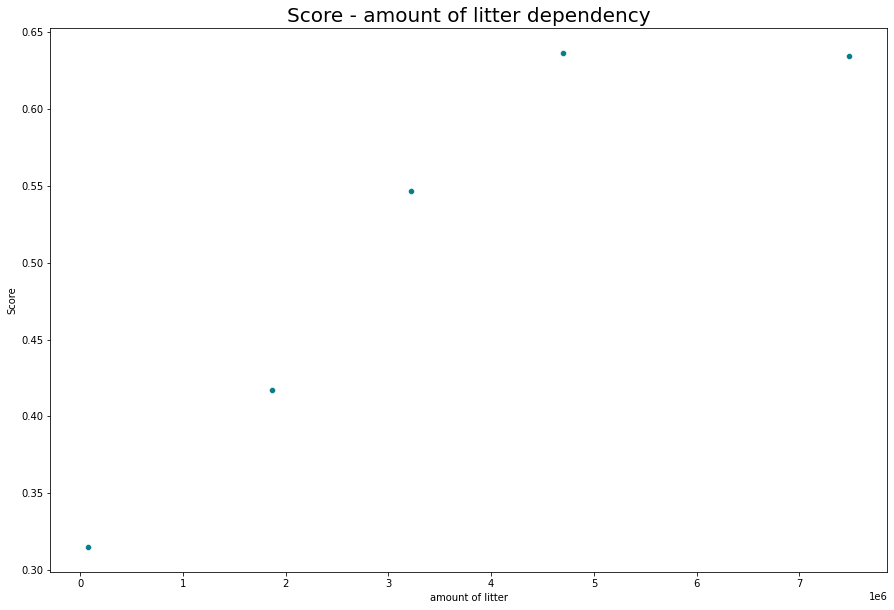

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_log_valeria, x='litter_sum', y='score', color='#087E8B', ax=ax)

ax.set_title('Score - amount of litter dependency', size=20)
ax.set_xlabel("amount of litter")
ax.set_ylabel("Score");
fig.show()
fig.savefig('Score_amount_of_litter_dependency.pdf');
files.download('Score_amount_of_litter_dependency.pdf')